In [1]:
import os
import json
import pdal
import laspy
import numpy as np

print(pdal.__version__)

3.4.5


In [2]:
file_index = 0

path_to_laz_dir = os.path.join(
    "data",
    "raw",
    "tiles",
    "laz"
)
print(f"Files in {path_to_laz_dir}")
files = os.listdir(path_to_laz_dir)
for i, file in enumerate(files):
    print(f"index: {i:<2}; {file}")

path_to_file = os.path.join(
    path_to_laz_dir,
    files[file_index]
)
print(os.path.exists(path_to_file))
print(path_to_file)

Files in data/raw/tiles/laz
index: 0 ; TAP_A03_2012_laz_10.copc.laz
index: 1 ; ANA_A01_2017_laz_10.laz
index: 2 ; ANA_A01_2017_laz_2.laz
index: 3 ; ANA_A01_2017_laz_1.laz
index: 4 ; ANA_A01_2017_laz_0.laz
index: 5 ; AND_A01_2013_laz_11.laz
index: 6 ; AND_A01_2013_laz_10.laz
index: 7 ; TAP_A03_2012_laz_10.laz
index: 8 ; ANA_A01_2018_LAS_11.laz
True
data/raw/tiles/laz/TAP_A03_2012_laz_10.copc.laz


In [3]:
las = laspy.read(path_to_file)

# Get classifications as a numpy array
classifications = las.classification

# Use numpy to count unique classes and occurrences
classes, counts = np.unique(classifications, return_counts=True)

all_counts = sum(counts)

# Print formatted table
print("Classification counts:")
print(f"{'Class':>10} {'Count':>10} {'Percent':>10}")
print("-" * 32)
for cl, ct in zip(classes, counts):
    percent = (ct / all_counts) * 100
    print(f"{cl:>10} {ct:>10} {percent:>9.0f} %")

Classification counts:
     Class      Count    Percent
--------------------------------
         2    1244995         3 %
         3    1826676         5 %
         4    2278441         6 %
         5   34235988        86 %


In [4]:
las = laspy.read(path_to_file)
min_x, max_x = las.x.min(), las.x.max()
min_y, max_y = las.y.min(), las.y.max()

print(f"X: {min_x:.2f} to {max_x:.2f}")
print(f"Y: {min_y:.2f} to {max_y:.2f}")

center_x = (min_x + max_x) / 2
center_y = (min_y + max_y) / 2

dx = (max_x - min_x) * 0.10 / 2  # 10% width, half on each side
dy = (max_y - min_y) * 0.10 / 2

xmin = center_x - dx
xmax = center_x + dx
ymin = center_y - dy
ymax = center_y + dy
print(f"Subset bounds:")
print(f"x=[{xmin:.2f}, {xmax:.2f}]")
print(f"y=[{ymin:.2f}, {ymax:.2f}]")

X: 726999.68 to 727923.67
Y: 9654999.80 to 9656000.17
Subset bounds:
x=[727415.48, 727507.87]
y=[9655449.97, 9655550.00]


In [ ]:
"type": "filters.crop",
    "bounds": "([727415.48, 727507.87],[9655449.97, 9655550.00])"

In [5]:
json_pipeline = """
[
    {
        "type": "readers.las",
        "filename": "data/raw/tiles/laz/TAP_A03_2012_laz_10.copc.laz"
    },
    {
        "type": "filters.info"
    }
]
"""

pipeline_def_tutorial = """
[
    {
        "type": "readers.las",
        "filename": "data/raw/tiles/laz/TAP_A03_2012_laz_10.copc.laz"
    },
    {
      "type":"filters.reprojection",
      "in_srs": "+proj=utm +zone=21 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs",
      "out_srs":"EPSG:32632"
    },
    {
      "type":"filters.assign",
      "value":"Classification = 0"
    },
    {
      "type":"filters.elm"
    },
    {
      "type":"filters.outlier"
    },
    {
      "type":"filters.smrf",
      "returns":"last",
      "where":"!(Classification == 7)",
      "slope":0.2,
      "window":16,
      "threshold":0.45,
      "scalar":1.2
    },
    {
      "type":"filters.expression",
      "expression":"Classification == 2"
    }
]
"""

pipeline_def_get_ground = """
[
    {
      "type": "readers.las",
      "filename": "data/raw/tiles/laz/TAP_A03_2012_laz_10.copc.laz"
    },
    {
      "type": "filters.crop",
      "bounds": "([727415.48, 727507.87],[9655449.97, 9655550.00])"
    },
    {
      "type": "filters.outlier"
    },
    {
      "type": "filters.csf", 
        "threshold": 0.2,
        "rigidness": 2, 
        "iterations": 500
    },
    {
      "type": "filters.range",
      "limits": "Classification[2:2]"
    },
    {
      "type": "writers.gdal",
      "filename": "csf_ground.tif",
      "resolution": 2.0,
      "output_type": "min",
      "gdaldriver": "GTiff"
    }
]
"""

# pipeline = pdal.Pipeline(json_pipeline)
pipeline = pdal.Pipeline(pipeline_def_get_ground)
count = pipeline.execute()
arrays = pipeline.arrays
metadata = pipeline.metadata
logs = pipeline.log
print(logs)

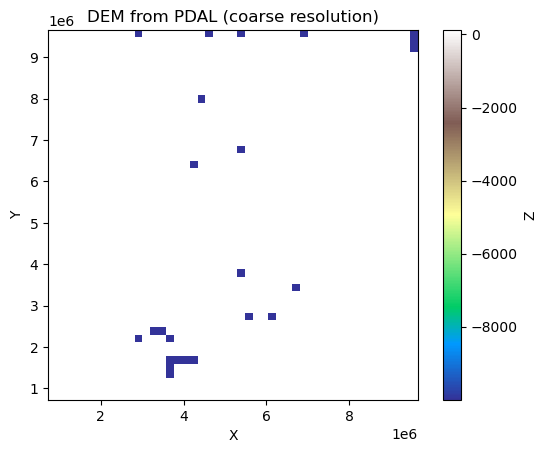

In [7]:
import rasterio
import matplotlib.pyplot as plt

with rasterio.open('csf_ground.tif') as src:
    dem = src.read(1)
    plt.imshow(dem, cmap='terrain', extent=src.bounds, origin='upper')
    plt.colorbar(label='Z')
    plt.title("DEM from PDAL (coarse resolution)")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

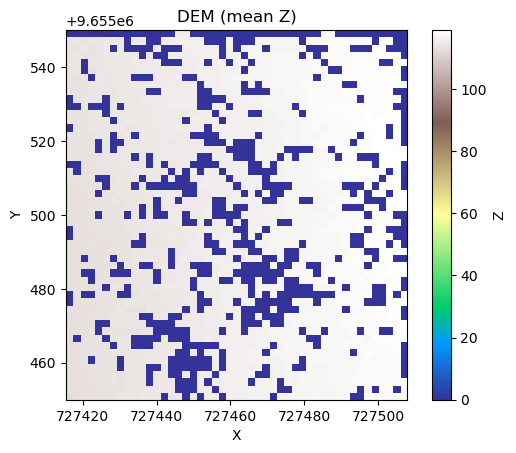

In [14]:
import numpy as np
import matplotlib.pyplot as plt

arr = pipeline.arrays[0]
# Define raster grid
xmin, xmax = arr['X'].min(), arr['X'].max()
ymin, ymax = arr['Y'].min(), arr['Y'].max()

res = 2.0  # cell size in same units as X/Y (e.g. meters)
# Set up bins
xbins = np.arange(xmin, xmax, res)
ybins = np.arange(ymin, ymax, res)

# Digitize to grid, then take max, mean, or min Z for each cell
xi = np.digitize(arr['X'], xbins) - 1
yi = np.digitize(arr['Y'], ybins) - 1

# Flat 2D grid for mean Z
dem = np.full((len(xbins), len(ybins)), np.nan)
counts = np.zeros((len(xbins), len(ybins)), dtype=int)

for x, y, z in zip(xi, yi, arr['Z']):
    if 0 <= x < dem.shape[0] and 0 <= y < dem.shape[1]:
        if np.isnan(dem[x, y]):
            dem[x, y] = z
        else:
            dem[x, y] += z
        counts[x, y] += 1

# Take mean
with np.errstate(invalid='ignore'):
    dem = dem / counts
    dem[np.isnan(dem)] = 0  # if you want to set no-data to 0

plt.imshow(dem.T, origin='lower', cmap='terrain',
           extent=[xmin, xmax, ymin, ymax])
plt.title('DEM (mean Z)')
plt.colorbar(label='Z')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()